# Prototype 02
#### Tasks
##### Done

## Training on Google Collab 

In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

## Training on Local Machine

In [1]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02


In [2]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [3]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


In [4]:
# Validate that python 3.10 is used
!python --version

Python 3.10.10


In [5]:
def seed_random():
    random.seed(42)
    torch.random.manual_seed(42)
    np.random.seed(42)

## --- Dependencies ---

In [6]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [7]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique
from src.data_provider import DataProvider
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent, evaluate_agent_on_afterstates
from src.autoencoder_utils import evaluate_ae_on_no_mtd_behavior, get_pretrained_ae

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from prototypes.prototype_02.sensor_environment import SensorEnvironment
from prototypes.prototype_02.agent import Agent
from prototypes.prototype_02.client import Client
from prototypes.prototype_02.enums import Execution, Evaluation
from prototypes.prototype_02.server import Server
from prototypes.prototype_02.experiment import Experiment

In [15]:
from sklearn.decomposition import PCA

train_data_pca, test_data_pca, _ = DataProvider.get_flat_train_test_split(pi=3, scale_normal_only=False)
print(train_data_pca.shape)
print(test_data_pca.shape)

(37361, 47)
(11718, 47)


In [85]:
import matplotlib.pyplot as plt

X_train_std = train_data_pca[:, :-1]

pca = PCA(n_components=14)
pca.fit(train_data_pca_x)
X_train_pca = pca.fit_transform(X_train_std)

# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

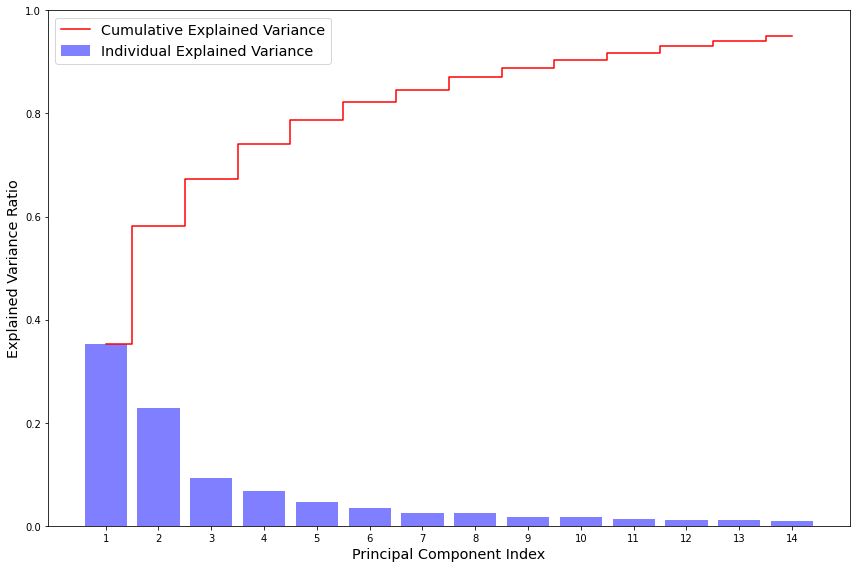

In [96]:
#
# Create the visualization plot
#
fontsize = 'x-large'
plt.figure(figsize=(12, 8))
plt.xticks(range(1, len(exp_var_pca)+1, 1))
plt.yticks(np.linspace(0,1,6))
plt.ylim(0,1)
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', color='blue', label='Individual Explained Variance')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid', color='red', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio', fontsize=fontsize)
plt.xlabel('Principal Component Index', fontsize=fontsize)
plt.legend(loc='best', fontsize=fontsize)
plt.tight_layout()
plt.show()

In [21]:
print(cum_sum_eigenvalues)

[0.35236475 0.58118324 0.67309289 0.73991876 0.78664383 0.82150344
 0.84607473 0.86994344 0.88729345 0.90427583 0.91802861 0.93021734
 0.94073695 0.95058111 0.95872159]


In [36]:
cumulative_explained_variances = {}

for n_components in range (1, 21):
    pca = PCA(n_components=n_components)
    pca.fit(train_data_pca_x)
    X_train_pca = pca.fit_transform(X_train_std)
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.sum(explained_variance)
    cumulative_explained_variances[n_components] = cumulative_explained_variance

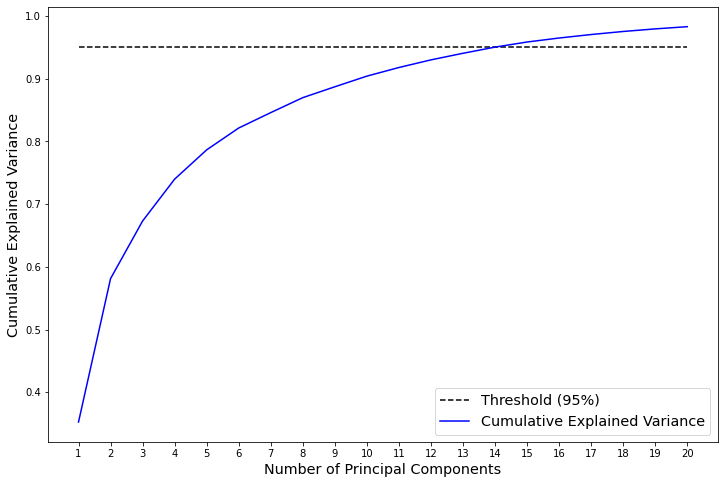

In [100]:
x = list(cumulative_explained_variances.keys())
y = list(cumulative_explained_variances.values())

fontsize = 'x-large'
plt.figure(figsize=(12, 8))
plt.xlabel('Number of Principal Components', fontsize=fontsize)
plt.ylabel('Cumulative Explained Variance', fontsize=fontsize)
plt.xticks(x)
#plt.ylim(0,1)
#plt.axhline(y=0.95, color='black', linestyle='dashed', label='Threshold (95%)')
plt.plot(x, [0.95]*len(x), color='black', linestyle='dashed', label='Threshold (95%)')
plt.plot(x, y, color='blue', label='Cumulative Explained Variance')
plt.legend(loc='lower right', fontsize=fontsize)
plt.show()

In [41]:
cumulative_explained_variances

{1: 0.3523647549593535,
 2: 0.5811832414015312,
 3: 0.673092892678218,
 4: 0.739918755234889,
 5: 0.7866438137851377,
 6: 0.8215034347229032,
 7: 0.8460746900206978,
 8: 0.8699434429187485,
 9: 0.8872934488334119,
 10: 0.9042758318786142,
 11: 0.9180285912197849,
 12: 0.9302173407209806,
 13: 0.9407369503348323,
 14: 0.950581104621539,
 15: 0.9587215950451,
 16: 0.965091447818696,
 17: 0.9706601202712388,
 18: 0.975532820798746,
 19: 0.9796722314557519,
 20: 0.9831779970727698}

In [35]:
print(y)

[0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747]


In [ ]:

#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## --- Hyperparameters ---

In [104]:
from typing import Dict
from src.custom_types import Behavior, MTDTechnique
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'
import joblib
import os
import pickle

def get_reduced_dimensions_with_pca_ds_as(dim=15, dir=""):
    ""
    dtrain, dtest, atrain, atest, scaler = DataProvider.get_scaled_scaled_train_test_split_with_afterstates(
        scaling_minmax=False)
    all_strain = dtrain[Behavior.NORMAL]
    for b in dtrain:
        if b != Behavior.NORMAL:
            all_strain = np.vstack((all_strain, dtrain[b]))
    for t, d in atrain.items():
        all_strain = np.vstack((all_strain, atrain[t][:, :-1]))

    pca = PCA(n_components=dim)
    pca.fit(all_strain[:, :-1])

    pca_dtrain = {}
    for b, d in dtrain.items():
        pca_dtrain[b] = np.hstack((pca.transform(d[:, :-1]), np.expand_dims(d[:, -1], axis=1)))

    pca_dtest = {}
    for b, d in dtest.items():
        pca_dtest[b] = np.hstack((pca.transform(d[:, :-1]), np.expand_dims(d[:, -1], axis=1)))

    pca_atrain = {}
    for t, d in atrain.items():
        pca_atrain[t] = np.hstack((pca.transform(d[:, :-2]), d[:, -2:]))

    pca_atest = {}
    for t, d in atest.items():
        pca_atest[t] = np.hstack((pca.transform(d[:, :-2]), d[:, -2:]))

    # save for later use for predictions preprocessing
    # scaler_file, pca_file = "scaler.gz", "pcafit.gz"
    scaler_file, pca_file = f"{dir}scalerdsas.obj", f"{dir}pcafitdsas.obj"

    if not os.path.isfile(scaler_file):
        joblib.dump(scaler, scaler_file[:-3] + "gz")
        with open(scaler_file, "wb") as sf:
            pickle.dump(scaler, sf)

    if not os.path.isfile(pca_file):
        joblib.dump(pca, pca_file[:-3] + "gz")
        with open(pca_file, "wb") as pf:
            pickle.dump(pca, pf)

    return pca_dtrain, pca_dtest, pca_atrain, pca_atest


def get_reduced_dimensions_with_pca(dim=15, pi=3, normal_only=True):
    strain, stest, scaler = DataProvider.get_scaled_train_test_split(pi=pi, scaling_minmax=False,
                                                                     scale_normal_only=normal_only)
    all_strain = strain[Behavior.NORMAL]
    for b in strain:
        if b != Behavior.NORMAL:
            all_strain = np.vstack((all_strain, strain[b]))

    # fit pca on all
    pca = PCA(n_components=dim)
    pca.fit(all_strain[:, :-1])

    pca_train = {}
    for b, d in strain.items():
        pca_train[b] = np.hstack((pca.transform(d[:, :-1]), np.expand_dims(d[:, -1], axis=1)))

    pca_test = {}
    for b, d in stest.items():
        pca_test[b] = np.hstack((pca.transform(d[:, :-1]), np.expand_dims(d[:, -1], axis=1)))

    # save for later use for predictions preprocessing
    # scaler_file, pca_file = "scaler.gz", "pcafit.gz"
    scaler_file, pca_file = "scaler.obj", "pcafit.obj"

    if not os.path.isfile(scaler_file):
        # joblib.dump(scaler, scaler_file)
        with open(scaler_file, "wb") as sf:
            pickle.dump(scaler, sf)

    if not os.path.isfile(pca_file):
        # joblib.dump(pca, pca_file)
        with open(pca_file, "wb") as pf:
            pickle.dump(pca, pf)

    return pca_train, pca_test


def fit_pca(n=15, pi=3):
    strain, stest, scaler = DataProvider.get_scaled_train_test_split(pi=pi, scale_normal_only=False, scaling_minmax=False)
    all_strain = strain[Behavior.NORMAL]
    for b in strain:
        if b != Behavior.NORMAL:
            all_strain = np.vstack((all_strain, strain[b]))

    pca = PCA(n_components=n)
    pca.fit(all_strain[:, :-1])
    return pca


def get_pca_loading_scores_dataframe(n=15):
    pca = DataProvider.fit_pca(n)
    loadings = pd.DataFrame(pca.components_,
                            columns=pd.read_csv(raw_behaviors_file_paths_rp3[Behavior.NORMAL]).drop(
                                time_status_columns + all_zero_columns + cols_to_exclude, axis=1).columns,
                            index=["PC" + str(i) for i in range(1, n + 1)])
    return loadings


def get_highest_weight_loading_scores_for_pc(n_pcs=15, pcn="PC1"):
    # maxCol = lambda x: max(x.min(), x.max(), key=abs)
    df = DataProvider.get_pca_loading_scores_dataframe(n_pcs)
    # df['max_loading_score'] = df.apply(maxCol, axis=1)
    sorted_pc = df.loc[pcn].reindex(df.loc[pcn].abs().sort_values(ascending=False).index)
    return sorted_pc


def split_ds_data_for_ae_and_rl(dtrain, s=0.3):
    normal_data = dtrain[Behavior.NORMAL]
    dtrain[Behavior.NORMAL] = normal_data[:int(s * len(normal_data))]
    return normal_data[int(s * len(normal_data)):], dtrain


def split_as_data_for_ae_and_rl(train_data, s=0.3):
    ae_dict = {}
    for mtd in MTDTechnique:
        normal_mtd_train = train_data[(Behavior.NORMAL, mtd)]
        train_data[(Behavior.NORMAL, mtd)] = normal_mtd_train[:int(s * len(normal_mtd_train))]
        ae_dict[mtd] = normal_mtd_train[int(s * len(normal_mtd_train)):]
    return ae_dict, train_data

In [9]:
# Hyperparams

GAMMA = 0.1 #0.99 # discount factor for future rewards
BATCH_SIZE = 100
N_EPISODES = 10000

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 1000

BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100
# Epsilon determining Exploration Exploitation Trade Off
EPSILON_START = 1.0
EPSILON_DEC = 1e-4 # 0.001
EPSILON_END = 0.01

TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-4
LOG_FREQ = 100
DIMS = 20
PI = 3
SAMPLES = 10

In [10]:
import os
import sys
import numpy as np
from src.autoencoder import AutoEncoder, AutoEncoderInterpreter
import torch
from src.evaluation_utils import calculate_metrics, check_anomalous
from src.custom_types import Behavior, MTDTechnique
from tabulate import tabulate


def split_data(data, split=0.8):
    row = int(len(data) * split)
    X_train = data[:row, :-1].astype(np.float32)
    X_valid = data[row:, :-1].astype(np.float32)

    return X_train, X_valid

def pretrain_autoencoder(autoencoder, lr=1e-4, momentum=0.9, num_epochs=100, num_std=2.5):
    autoencoder.pretrain(optimizer=torch.optim.SGD(autoencoder.model.parameters(), lr=lr, momentum=momentum), num_epochs=num_epochs)
    return autoencoder

In [91]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=PI, scaling_minmax=True,
                                                                         scale_normal_only=True)
# get splits for RL & AD of normal data
n = 100
s = 0.3
b = Behavior.NORMAL
normal_data = train_data[b]
l = len(normal_data)

train_data[b] = normal_data[:int(l * s)]  # use fixed number of samples for Reinforcement Agent training
# COMMENT/UNCOMMENT BELOW for pretraining of autoencoder

ae_data = normal_data[int(l * s):]  # use remaining samples for autoencoder
ae_train_x, ae_valid_x = split_data(ae_data)

flattend_test_data = np.empty([0,47])
for behavior, behavior_data in test_data.items():
    print(f"{behavior}: {len(behavior_data)} samples")
    
    if behavior == Behavior.NORMAL:
        n_samples = 2800
        behavior_data[:, -1] =  0
    else:
        n_samples = 400
        behavior_data[:, -1] = 1
    y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * n_samples)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:n_samples]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
print(f"type(ae_test_x) = {type(ae_test_x)}")
print(f"ae_test_x.dtype = {ae_test_x.dtype}")
ae_test_y = flattend_test_data[:,-1].astype(int)
print(f"type(ae_test_y) = {type(ae_test_y)}")
print(f"ae_test_y.dtype = {ae_test_y.dtype}")

print(f"Training Data: X.shape = {ae_train_x.shape}")
#print(f"Validation Data: X.shape = {ae_valid_x.shape}")   
print(f"Test Data: X.shape = {ae_test_x.shape}; y.shape = {ae_test_y.shape}")

evaluation_data = {}
for behavior, behavior_data in train_data.items():
    print(f"{behavior}: {len(behavior_data)} samples")
    if behavior == Behavior.NORMAL:
        evaluation_data[behavior] = behavior_data[:2800]
    else:
        evaluation_data[behavior] = behavior_data[:400]

Behavior.NORMAL: 2930 samples
Behavior.RANSOMWARE_POC: 1866 samples
Behavior.ROOTKIT_BDVL: 1129 samples
Behavior.ROOTKIT_BEURK: 1461 samples
Behavior.CNC_THETICK: 1531 samples
Behavior.CNC_BACKDOOR_JAKORITAR: 852 samples
Behavior.CNC_OPT1: 1127 samples
Behavior.CNC_OPT2: 822 samples
type(ae_test_x) = <class 'numpy.ndarray'>
ae_test_x.dtype = object
type(ae_test_y) = <class 'numpy.ndarray'>
ae_test_y.dtype = int64
Training Data: X.shape = (5375, 46)
Test Data: X.shape = (5600, 46); y.shape = (5600,)
Behavior.NORMAL: 2879 samples
Behavior.RANSOMWARE_POC: 6181 samples
Behavior.ROOTKIT_BDVL: 3406 samples
Behavior.ROOTKIT_BEURK: 4744 samples
Behavior.CNC_THETICK: 4952 samples
Behavior.CNC_BACKDOOR_JAKORITAR: 2380 samples
Behavior.CNC_OPT1: 3655 samples
Behavior.CNC_OPT2: 2544 samples


In [92]:
from torch import nn
from skorch import NeuralNetClassifier
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score


def auto_encoder_architecture_01(in_features: int, activation_function):
    nn_l1 = 20
    nn_l2 = 10
    nn_l3 = 5
    
    '''
    modules = []
    modules.append(nn.Linear(in_features, nn_l1))
    modules.append(nn.BatchNorm1d(nn_l1)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l1, nn_l2)),
    modules.append(activation_function),
    modules.append(nn.Dropout(p=0.2)),
    modules.append(nn.Linear(nn_l2, nn_l3)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l3, nn_l3)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l3, nn_l2)),
    modules.append(activation_function),
    modules.append(nn.Dropout(p=0.2)),
    modules.append(nn.Linear(nn_l2, nn_l1)),
    modules.append(nn.BatchNorm1d(nn_l1)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l1, in_features)),
    modules.append(activation_function)
    model = nn.Sequential(*modules)
    '''
    
    #model = nn.Sequential(
    #    nn.Linear(in_features, nn_l1),
    #    nn.BatchNorm1d(nn_l1),
    #    nn.GELU(),
    #    nn.Linear(nn_l1, nn_l2),
    #    nn.GELU(),
    #    nn.Linear(nn_l2, nn_l3),
    #    nn.GELU(),
    #    nn.Linear(nn_l3, nn_l3),
    #    nn.GELU(),
    #    nn.Linear(nn_l3, nn_l2),
    #    nn.GELU(),
    #    nn.Linear(nn_l2, nn_l1),
    #    nn.BatchNorm1d(nn_l1),
    #    nn.GELU(),
    #    nn.Linear(nn_l1, in_features),
    #    nn.GELU()
    #)
    nn_bottleneck = 8
    model = nn.Sequential(
        nn.Linear(in_features, nn_bottleneck),
        nn.GELU(),
        nn.Linear(nn_bottleneck, in_features),
        nn.GELU(),
    )
    return model


class AutoEncoder(torch.nn.Module):
    

    def __init__(self, X_valid, X_test, y_test, evaluation_data, num_stds, activation_function, batch_size: int = 64, verbose=False):

        super().__init__()
        
        '''
        training_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train).type(torch.float),
            #torch.from_numpy(train_y).type(torch.float)
        )
        self.training_data_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        '''
        
        validation_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_valid).type(torch.float),

        )
        self.validation_data_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True, drop_last=True)


        self.X_test = X_test
        self.y_test = y_test
        
        self.evaluation_data = evaluation_data
        
        self.num_stds = num_stds
        
        n_features = X_test.shape[1]
        #self.model =  auto_encoder_architecture_01(n_features, activation_function)
        nn_l1 = 24
        nn_l2 = 12
        #nn_l3 = 6
        #nn_l4 = 4
        self.model = nn.Sequential(
            nn.Linear(n_features, nn_l1),
            nn.BatchNorm1d(nn_l1),
            activation_function,
            nn.Linear(nn_l1, nn_l2),
            activation_function,
            #nn.Linear(nn_l2, nn_l3),
            #activation_function,
            #nn.Linear(nn_l3, nn_l4),
            #activation_function,
            #nn.Linear(nn_l4, nn_l3),
            #activation_function,
            #nn.Linear(nn_l3, nn_l2),
            #activation_function,
            nn.Linear(nn_l2, nn_l1),
            nn.BatchNorm1d(nn_l1),
            activation_function,
            nn.Linear(nn_l1, n_features),
            activation_function,
        )
        self.threshold = None
        self.loss_mean = None
        self.loss_standard_deviation = None

        
    def forward(self, X):
        return self.model(X)
    
    
    def pretrain(self, optimizer=torch.optim.SGD, loss_function=torch.nn.MSELoss(reduction='sum'), num_epochs: int = 15, batch_size=64):
        
        training_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train).type(torch.float),
        )
        training_data_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        epoch_losses = []
        #for e in tqdm(range(num_epochs), unit="epoch", leave=False):
        for e in range(num_epochs):
            self.model.train()
            current_losses = []
            for batch_index, (inputs,) in enumerate(training_data_loader):
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_function(inputs, outputs)
                loss.backward()
                optimizer.step()
                current_losses.append(loss.item())
            
            epoch_losses.append(np.average(current_losses))
            if e == 0 or e == (num_epochs - 1):
                print(f'Training Loss in epoch {e + 1}: {epoch_losses[e]}')
            
        self.analyze_loss()

    '''
    This function uses normal data samles 
    after training the autoencoder to determine
    values that can be considered normal
    for the reconstruction loss based on normal samples
    '''
    def analyze_loss(self):
        losses = []
        
        self.model.eval() 
        with torch.no_grad():
            loss_function = torch.nn.MSELoss(reduction='sum')
            for batch_index, (inputs,) in enumerate(self.validation_data_loader):
                outputs = self.model(inputs)
                loss = loss_function(inputs, outputs)
                losses.append(loss.item())
        
        losses = np.array(losses)

        self.loss_mean = losses.mean()
        self.loss_standard_deviation = losses.std()

        
    def predict(self, x, num_std = 1):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        all_predictions = torch.tensor([])  # .cuda()

        self.model.eval()
        with torch.no_grad():
            ae_loss = torch.nn.MSELoss(reduction="sum")
            for idx, (batch_x,) in enumerate(test_data_loader):
                #batch_x = batch_x  # .cuda()
                model_predictions = self.model(batch_x)

                model_predictions = ae_loss(model_predictions, batch_x).unsqueeze(0)  # unsqueeze as batch_size set to 1
                all_predictions = torch.cat((all_predictions, model_predictions))

        #threshold = self.compute_threshold(num_std)
        threshold = self.loss_mean + num_std * self.loss_standard_deviation
        all_predictions = (all_predictions > threshold).type(torch.long)
        return all_predictions.flatten()
    
    
    def predict_deviation(self, x):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        prediction_errors = torch.tensor([])
        loss_function = torch.nn.MSELoss(reduction="sum")
        
        self.model.eval()
        with torch.no_grad():
            
            for batch_index, (inputs,) in enumerate(test_data_loader):
                prediction = self.model(inputs)
                prediction_error = loss_function(inputs, prediction).unsqueeze(0)  # unsqueeze as batch_size set to 1
                prediction_errors = torch.cat((prediction_errors, prediction_error))

        return prediction_errors
    
    
    def score(self):
        num_std, accuracy = self.accuracy_score(None, None)
        print(f"Evaluation performed with best num_std={num_std}")
        self.evaluate(num_std)
        return accuracy
    
    
    def accuracy_score(self, X, y):
        #if not self.threshold:
        #loss_mean, loss_standard_deviation = self.analyze_loss(X)
        #num_stds = np.arange(0.1, 3, 0.1)
        if self.loss_mean == None or self.loss_standard_deviation == None:
              #print("accuracy_score_optimized > accurcy_loss()")
              self.analyze_loss()
    
        best_accuracy = 0
        best_num_std = 0
        #accuracies = []
        y_dev = self.predict_deviation((self.X_test).astype(np.float32))
        for num_std in self.num_stds:
            y_true = self.y_test
            threshold = self.loss_mean + num_std * self.loss_standard_deviation
            y_pred = (y_dev > threshold).type(torch.long).detach().cpu().numpy()
            
            accuracy = accuracy_score(y_true, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_std = num_std
            print(f"num_std {num_std:.2f} -> accuracy: {accuracy}")

        return best_num_std, best_accuracy
    
    
    def evaluate(self, num_std=0.1):
        results = []
        labels= [0,1]

        y_true_total = np.empty([0])
        y_pred_total = np.empty([0])
        for behavior, data in self.evaluation_data.items():
            y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * len(data)).astype(int)
            y_true_total = np.concatenate((y_true_total, y_true))

            y_pred = self.predict(data[:, :-1].astype(np.float32), num_std=0.2)
            y_pred_total = np.concatenate((y_pred_total, y_pred))

            if behavior == Behavior.NORMAL:
                pos_label = 0
            else:
                pos_label = 1

            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, labels=labels, pos_label=pos_label, zero_division=1)
            recall = recall_score(y_true, y_pred, labels=labels, pos_label=pos_label, zero_division=1)
            f1 = f1_score(y_true, y_pred, labels=labels, pos_label=pos_label, zero_division=1)
            n_samples = len(y_true)
            results.append([behavior, f'{(100 * accuracy):.2f}%', f'{(100 * precision):.2f}%', f'{(100 * recall):.2f}%', f'{(100 * f1):.2f}%', n_samples])

        accuracy = accuracy_score(y_true_total, y_pred_total)
        precision = precision_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        recall = recall_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        f1 = f1_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        n_samples = len(y_true_total)
        results.append(["GLOBAL", f'{(100 * accuracy):.2f}%', f'{(100 * precision):.2f}%', f'{(100 * recall):.2f}%', f'{(100 * f1):.2f}%', n_samples])

        print(tabulate(results, headers=["Behavior", "Accuracy", "Precision", "Recall", "F1-Score", "#Samples"], tablefmt="pipe"))
        print("-----------")

In [93]:
import skorch
from skorch import NeuralNet, NeuralNetRegressor
from skorch.scoring import loss_scoring

class StateAnomalyDetector(skorch.NeuralNet):
    def score(self, X, y=None):
        return self.module_.score()
    
    def evaluate(self):
        self.module_.evaluate()

In [45]:
autoencoder = AutoEncoder(ae_valid_x, ae_test_x, ae_test_y, train_data, [0.1], torch.nn.GELU(), 64)

In [1003]:
autoencoder.pretrain(optimizer=torch.optim.SGD(autoencoder.model.parameters(), lr=1e-4, momentum=0.9), num_epochs=100, batch_size=64)

WHICH TRAINING FUNCTION GETS USED HERE???
Training Loss in epoch 1: 141.34349115210844
Training Loss in epoch 2: 48.83870605101068
Training Loss in epoch 3: 41.856073080775246
Training Loss in epoch 4: 36.52442994175187
Training Loss in epoch 5: 33.66350785220962
Training Loss in epoch 6: 32.19872555100774
Training Loss in epoch 7: 29.301351593201417
Training Loss in epoch 8: 27.75120712188353
Training Loss in epoch 9: 26.90066507638219
Training Loss in epoch 10: 26.320698450846844
Training Loss in epoch 11: 25.708706407661897
Training Loss in epoch 12: 25.35671031905944
Training Loss in epoch 13: 24.66605770157044
Training Loss in epoch 14: 24.08588276139225
Training Loss in epoch 15: 23.818487695900792
Training Loss in epoch 16: 23.40227699279785
Training Loss in epoch 17: 23.547896764364587
Training Loss in epoch 18: 23.574263423322193
Training Loss in epoch 19: 22.771034286682863
Training Loss in epoch 20: 22.311615059174688
Training Loss in epoch 21: 21.8167615683682
Training Loss

In [1004]:
autoencoder.evaluate()

| Behavior                        | Accuracy   | Precision   | Recall   | F1-Score   |
|:--------------------------------|:-----------|:------------|:---------|:-----------|
| Behavior.NORMAL                 | 56.30%     | 100.00%     | 56.30%   | 72.04%     |
| Behavior.RANSOMWARE_POC         | 100.00%    | 100.00%     | 100.00%  | 100.00%    |
| Behavior.ROOTKIT_BDVL           | 100.00%    | 100.00%     | 100.00%  | 100.00%    |
| Behavior.ROOTKIT_BEURK          | 42.64%     | 100.00%     | 42.64%   | 59.79%     |
| Behavior.CNC_THETICK            | 64.05%     | 100.00%     | 64.05%   | 78.09%     |
| Behavior.CNC_BACKDOOR_JAKORITAR | 41.85%     | 100.00%     | 41.85%   | 59.00%     |
| Behavior.CNC_OPT1               | 98.74%     | 100.00%     | 98.74%   | 99.37%     |
| Behavior.CNC_OPT2               | 100.00%    | 100.00%     | 100.00%  | 100.00%    |
| GLOBAL                          | 76.61%     | 94.58%      | 78.71%   | 85.92%     |


In [94]:
from skorch.callbacks import Callback

class PostTrainingEvaluation(Callback):
    #def __init__(self):
    #    super.__init__()

    def on_train_end(self, model, **kwargs):
        model.evaluate()

In [99]:
from skorch import NeuralNet, NeuralNetRegressor
from skorch.callbacks import LRScheduler, EarlyStopping

model = StateAnomalyDetector(
    module=AutoEncoder,
    max_epochs=100,
    
    criterion=torch.nn.MSELoss(reduction='sum'),
    optimizer=torch.optim.SGD,
    optimizer__lr=0.0001,
    optimizer__weight_decay=0.01
    
    iterator_train__shuffle=True,
    
    batch_size=32,
    #iterator_train__batch_size=64,
    #iterator_valid__batch_size=1,
    #train_split=predefined_split(validation_dataset),
    #device='cuda',
    module__X_valid=ae_valid_x,
    module__X_test=ae_test_x,
    module__y_test=ae_test_y,
    module__evaluation_data=evaluation_data,
    module__activation_function=nn.GELU(),
    module__num_stds=np.linspace(0.1, 3, 30),
    module__verbose=False,
    
    verbose=True,
    
    #callbacks=[EarlyStopping(patience=7, monitor='valid_loss'), PostTrainingEvaluation()]
    callbacks=[EarlyStopping(patience=7, monitor='valid_loss')]
    #callbacks='disable'
)

In [83]:
model.fit(ae_train_x, ae_train_x);

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      146.1831      102.3982  0.2765
      2       75.5247       61.4449  0.2337
      3       52.3268       45.3099  0.2997
      4       42.0520       36.5069  0.4274
      5       35.8289       30.5301  0.2765
      6       29.7551       26.0806  0.2344
      7       26.8061       24.8236  0.4496
      8       25.2553       23.1518  0.2922
      9       24.3616       22.0730  0.3146
     10       23.4817       21.3700  0.2292
     11       22.8800       20.7547  0.2310
     12       22.0578       20.0303  0.2704
     13       21.8855       19.5038  0.2980
     14       20.9751       18.9526  0.4469
     15       20.5147       18.6890  0.3215
     16       19.7924       18.0358  0.3686
     17       19.7156       17.8777  0.2451
     18       18.8507       17.3011  0.2222
     19       18.9544       17.1063  0.2999
     20       18.5193       17.2366  0.3137
     21       17.8432       16.4

In [102]:
# Dropout. Dropout causes a fraction of neurons to be discarded randomly during training.
# This helps to reduce overfitting. Values of dropout tested are 0, 0.1 and 0.2

# nn.GELU(),

print(model)

from torch.optim.lr_scheduler import StepLR

#scheduler = StepLR(optimizer, 
#                   step_size = 4, # Period of learning rate decay
#                   gamma = 0.5) # Multiplicative factor of learning rate decay

from sklearn.model_selection import GridSearchCV
param_grid = {
    'verbose': [False],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    #'optimizer__weight_decay': [0.00001],
    #'scheduler': [StepLR( 
    #               step_size = 4, # Period of learning rate decay
    #               gamma = 0.5)],
    'lr': [0.0001, 0.00001],
    'optimizer__weight_decay': [0.01],
    #'lr' : [0.0001],
    'max_epochs': [20],
    'batch_size': [64],
    'module__activation_function': [torch.nn.Tanh(), torch.nn.GELU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.ELU()]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2, verbose=5, refit=True)
grid_search_result = grid_search.fit(ae_train_x, ae_train_x)

<class '__main__.StateAnomalyDetector'>[uninitialized](
  module=<class '__main__.AutoEncoder'>,
  module__X_test=[[0.12299465240641712 0.4 0.2222222222222222 ... 0.0 0.0
    0.3333333333333333]
   [0.10160427807486633 0.0 0.0 ... 0.0 0.0 0.3333333333333333]
   [0.08021390374331551 0.4 0.2222222222222222 ... 0.0 0.0
    0.3333333333333333]
   ...
   [0.2406417112299465 0.9333333333333333 0.7777777777777777 ... 1.0 1.0
    0.6666666666666666]
   [0.8716577540106953 0.13333333333333333 0.2222222222222222 ... 0.0 0.0
    0.3333333333333333]
   [0.16577540106951869 0.9333333333333333 0.7777777777777777 ...
    0.3333333333333333 0.0 0.6666666666666666]],
  module__X_valid=[[0.12299465 0.4        0.22222222 ... 0.         0.         0.33333334]
   [0.18181819 0.4        0.33333334 ... 0.         0.         0.33333334]
   [0.14438502 0.53333336 0.44444445 ... 0.33333334 0.5        0.6666667 ]
   ...
   [0.42780748 0.4        0.22222222 ... 0.         0.         0.33333334]
   [0.11229946 0.8

KeyboardInterrupt: 

In [54]:
import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
results.head(10)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [966]:
best_result = results[results["rank_test_score"] == 1]
print(best_result)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15       8.090364      0.123482         3.110779         0.48372   

   param_batch_size param_lr param_max_epochs  \
15               64  0.00001              100   

   param_module__activation_function                  param_optimizer  \
15                            Tanh()  <class 'torch.optim.adam.Adam'>   

   param_verbose                                             params  \
15         False  {'batch_size': 64, 'lr': 1e-05, 'max_epochs': ...   

    split0_test_score  split1_test_score  mean_test_score  std_test_score  \
15           0.679553           0.685612         0.682582         0.00303   

    rank_test_score  
15                1  


In [516]:
best_estimator = grid_search_result.best_estimator_
best_autoencoder = grid_search_result.best_estimator_.module_
best_autoencoder.evaluate()

(2879,)
torch.Size([2879])
(6181,)
torch.Size([6181])
(3406,)
torch.Size([3406])
(4744,)
torch.Size([4744])
(4952,)
torch.Size([4952])
(2380,)
torch.Size([2380])
(3655,)
torch.Size([3655])
(2544,)
torch.Size([2544])
Manually computed accuracy: 1.0
\begin{tabular}{lllll}
\hline
 Behavior                        & Accuracy   & Precision   & Recall   & F1-Score   \\
\hline
 Behavior.NORMAL                 & 0.00\%      & 0.00\%       & 100.00\%  & 0.00\%      \\
 Behavior.RANSOMWARE\_POC         & 100.00\%    & 100.00\%     & 100.00\%  & 100.00\%    \\
 Behavior.ROOTKIT\_BDVL           & 100.00\%    & 100.00\%     & 100.00\%  & 100.00\%    \\
 Behavior.ROOTKIT\_BEURK          & 100.00\%    & 100.00\%     & 100.00\%  & 100.00\%    \\
 Behavior.CNC\_THETICK            & 100.00\%    & 100.00\%     & 100.00\%  & 100.00\%    \\
 Behavior.CNC\_BACKDOOR\_JAKORITAR & 100.00\%    & 100.00\%     & 100.00\%  & 100.00\%    \\
 Behavior.CNC\_OPT1               & 100.00\%    & 100.00\%     & 100.00\%  &

In [706]:
np.max(results["mean_test_score"])

0.6980713432326335

-----------
## --- Experiments ---
### Experiment 01

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

environment_01 = SensorEnvironment(train_data)
environment_02 = SensorEnvironment(train_data)

print(environment_01.observation_space_size)

global_agent = Agent(0, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.LEARNING_CURVE, Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1)

### Experiment 01

In [12]:
'''
import os
import sys
import numpy as np
from src.autoencoder import AutoEncoder, AutoEncoderInterpreter
import torch
from src.evaluation_utils import calculate_metrics, check_anomalous
from src.custom_types import Behavior, MTDTechnique
from tabulate import tabulate


def pretrain_autoencoder(ae_data, split=0.8, lr=1e-4, momentum=0.9, num_epochs=100, num_std=2.5,
                      path="experiments/experiment_03/trained_models/ae_model.pth"):
    idx = int(len(ae_data) * split)
    train_ae_x = ae_data[:idx, :-1].astype(np.float32)
    valid_ae_x = ae_data[idx:, :-1].astype(np.float32)
    print(f"size train: {train_ae_x.shape}, size valid: {valid_ae_x.shape}")

    print("---Training AE---")
    ae = AutoEncoder(train_x=train_ae_x, valid_x=valid_ae_x)
    ae.train(optimizer=torch.optim.SGD(ae.model.parameters(), lr=lr, momentum=momentum), num_epochs=num_epochs)
    ae.analyze_loss(num_std=num_std)
    print(f"AE threshold: {ae.threshold}")
    ae.save_model(path=path)
    return train_ae_x, valid_ae_x
'''

'\nimport os\nimport sys\nimport numpy as np\nfrom src.autoencoder import AutoEncoder, AutoEncoderInterpreter\nimport torch\nfrom src.evaluation_utils import calculate_metrics, check_anomalous\nfrom src.custom_types import Behavior, MTDTechnique\nfrom tabulate import tabulate\n\n\ndef pretrain_autoencoder(ae_data, split=0.8, lr=1e-4, momentum=0.9, num_epochs=100, num_std=2.5,\n                      path="experiments/experiment_03/trained_models/ae_model.pth"):\n    idx = int(len(ae_data) * split)\n    train_ae_x = ae_data[:idx, :-1].astype(np.float32)\n    valid_ae_x = ae_data[idx:, :-1].astype(np.float32)\n    print(f"size train: {train_ae_x.shape}, size valid: {valid_ae_x.shape}")\n\n    print("---Training AE---")\n    ae = AutoEncoder(train_x=train_ae_x, valid_x=valid_ae_x)\n    ae.train(optimizer=torch.optim.SGD(ae.get_model().parameters(), lr=lr, momentum=momentum), num_epochs=num_epochs)\n    ae.determine_threshold(num_std=num_std)\n    print(f"AE threshold: {ae.threshold}")\n   

In [54]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)


seed_random()

# read in all preprocessed data for a simulated, supervised environment to sample from
# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI)
train_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=PI, scaling_minmax=True,
                                                                         scale_normal_only=True)
# get splits for RL & AD of normal data
n = 100
s = 0.3
b = Behavior.NORMAL
normal_data = train_data[b]
l = len(normal_data)
cutoff = int(l * s)

train_data[b] = normal_data[:cutoff]  

ae_data = normal_data[cutoff:] 
X_train, X_valid = split_data(ae_data)
print(f"X_train: {len(X_train)}, X_valid: {len(X_valid)}")

X_train: 5375, X_valid: 1344


In [23]:

from skorch.dataset import Dataset
from skorch.helper import predefined_split

training_dataset = Dataset(X_train, X_train)
#training_dataset = predefined_split(training_dataset)

validation_dataset = Dataset(X_valid, X_valid)
validation_dataset = predefined_split(validation_dataset)

In [ ]:
skorch.callbacks.BatchScoring(scoring, lower_is_better=True, on_train=False, name=None, target_extractor=<function to_numpy>, use_caching=True)

In [377]:
# def score(self, X, y):
# y = self.predict(X)
# return sklearn.metrics.mean_squared_error(y, y_pred)
print(model.initialize())
#print(model.criterion)

<class '__main__.StateAnomalyDetector'>[initialized](
  module_=AutoEncoder(
    (model): Sequential(
      (0): Linear(in_features=46, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): GELU(approximate='none')
      (5): Linear(in_features=8, out_features=4, bias=True)
      (6): GELU(approximate='none')
      (7): Linear(in_features=4, out_features=4, bias=True)
      (8): GELU(approximate='none')
      (9): Linear(in_features=4, out_features=8, bias=True)
      (10): GELU(approximate='none')
      (11): Linear(in_features=8, out_features=16, bias=True)
      (12): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): GELU(approximate='none')
      (14): Linear(in_features=16, out_features=46, bias=True)
      (15): GELU(approximate='none')
    )
  ),
)


In [378]:
res = model.fit(X_full, X_full)

Re-initializing module because the following parameters were re-set: X_test, activation_function, y_test.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      112.9418       52.4199  0.2122
      2       85.8176       53.4512  0.1819
      3       78.0073       40.6834  0.1779
      4       78.1281       81.8137  0.1852
      5       86.7565      431.3448  0.1831
      6      103.1512       48.4825  0.1748
      7      100.7464       48.0129  0.1736
      8      100.6981       50.5439  0.1818
      9      100.5672       47.4598  0.1761
     10      105.9573       57.2735  0.1750
     11       96.7975       49.0236  0.1749
     12       87.1647       76.8107  0.1732
     13       84.4378      143.9594  0.1753
     14       82.8813       37.2244  0.1722
     15       73.5040       35.0922  0.1785
     16       72.9861       37.2828  0.1747
     17       73.8891       32.5287  0.1842
    

In [379]:
evaluate_autoencoder(model.module_, train_data)

Which prediction function is called
(2879,)
torch.Size([2879])
Which prediction function is called
(6181,)
torch.Size([6181])
Which prediction function is called
(3406,)
torch.Size([3406])
Which prediction function is called
(4744,)
torch.Size([4744])
Which prediction function is called
(4952,)
torch.Size([4952])
Which prediction function is called
(2380,)
torch.Size([2380])
Which prediction function is called
(3655,)
torch.Size([3655])
Which prediction function is called
(2544,)
torch.Size([2544])
Which prediction function is called
Manually computed accuracy: 1.0
\begin{tabular}{lllll}
\hline
 Behavior                        & Accuracy   & Precision   & Recall   & F1-Score   \\
\hline
 Behavior.NORMAL                 & 0.00\%      & 0.00\%       & 100.00\%  & 0.00\%      \\
 Behavior.RANSOMWARE\_POC         & 100.00\%    & 100.00\%     & 100.00\%  & 100.00\%    \\
 Behavior.ROOTKIT\_BDVL           & 100.00\%    & 100.00\%     & 100.00\%  & 100.00\%    \\
 Behavior.ROOTKIT\_BEURK     

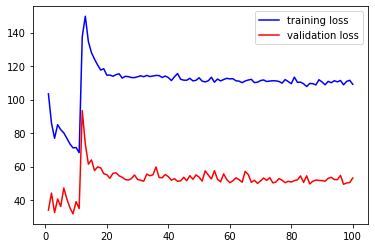

In [229]:
history = model.history
plot_loss_history(history)


In [228]:
import matplotlib.pyplot as plt

def plot_loss_history(history):
    epochs = history[:, 'epoch']
    training_losses = history[:, 'train_loss']
    validation_losses = history[:, 'valid_loss']
    plt.plot(epochs, training_losses, color='blue', label='training loss')
    plt.plot(epochs, validation_losses, color='red', label='validation loss')
    plt.legend()
    plt.show()

In [136]:
evaluate_autoencoder(model.module, test_data=train_data)

TypeError: AutoEncoder.predict() missing 1 required positional argument: 'x'

In [292]:
import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_max_epochs,param_module__activation_function,param_optimizer,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1.102578,0.026118,0.000034,0.000000e+00,0.001,10,GELU(approximate='none'),<class 'torch.optim.adam.Adam'>,"{'lr': 0.001, 'max_epochs': 10, 'module__activ...",0.7,0.7,0.7,0.0,1
1,0.975618,0.035682,0.000038,3.933907e-06,0.001,10,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,"{'lr': 0.001, 'max_epochs': 10, 'module__activ...",0.7,0.7,0.7,0.0,1
2,0.926229,0.017654,0.000037,3.933907e-06,0.001,10,ReLU(),<class 'torch.optim.adam.Adam'>,"{'lr': 0.001, 'max_epochs': 10, 'module__activ...",0.7,0.7,0.7,0.0,1
3,0.731420,0.060926,0.000035,1.192093e-07,0.001,10,ReLU(),<class 'torch.optim.sgd.SGD'>,"{'lr': 0.001, 'max_epochs': 10, 'module__activ...",0.7,0.7,0.7,0.0,1
4,1.251889,0.062733,0.000039,3.099442e-06,0.0001,10,GELU(approximate='none'),<class 'torch.optim.adam.Adam'>,"{'lr': 0.0001, 'max_epochs': 10, 'module__acti...",0.7,0.7,0.7,0.0,1
5,0.847597,0.013039,0.000036,1.311302e-06,0.0001,10,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,"{'lr': 0.0001, 'max_epochs': 10, 'module__acti...",0.7,0.7,0.7,0.0,1
6,0.917123,0.003687,0.000060,1.537800e-05,0.0001,10,ReLU(),<class 'torch.optim.adam.Adam'>,"{'lr': 0.0001, 'max_epochs': 10, 'module__acti...",0.7,0.7,0.7,0.0,1
7,0.784601,0.020679,0.000040,5.960464e-07,0.0001,10,ReLU(),<class 'torch.optim.sgd.SGD'>,"{'lr': 0.0001, 'max_epochs': 10, 'module__acti...",0.7,0.7,0.7,0.0,1


In [380]:
print(grid_result.best_estimator_.module_)

AutoEncoder(
  (model): Sequential(
    (0): Linear(in_features=46, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): GELU(approximate='none')
    (5): Linear(in_features=8, out_features=4, bias=True)
    (6): GELU(approximate='none')
    (7): Linear(in_features=4, out_features=4, bias=True)
    (8): GELU(approximate='none')
    (9): Linear(in_features=4, out_features=8, bias=True)
    (10): GELU(approximate='none')
    (11): Linear(in_features=8, out_features=16, bias=True)
    (12): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): GELU(approximate='none')
    (14): Linear(in_features=16, out_features=46, bias=True)
    (15): GELU(approximate='none')
  )
)


In [112]:
evaluate_autoencoder(grid_result.best_estimator_, test_data=train_data)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [86]:
sorted(grid_result.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_lr',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [90]:
grid_result.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__module': __main__.AutoEncoder,
 'estimator__criterion': MSELoss(),
 'estimator__optimizer': torch.optim.sgd.SGD,
 'estimator__lr': 0.01,
 'estimator__max_epochs': 10,
 'estimator__batch_size': 32,
 'estimator__iterator_train': torch.utils.data.dataloader.DataLoader,
 'estimator__iterator_valid': torch.utils.data.dataloader.DataLoader,
 'estimator__dataset': skorch.dataset.Dataset,
 'estimator__train_split': <skorch.dataset.ValidSplit object at 0x142717e50>,
 'estimator__callbacks': None,
 'estimator__predict_nonlinearity': 'auto',
 'estimator__warm_start': False,
 'estimator__verbose': True,
 'estimator__device': 'cpu',
 'estimator___params_to_validate': {'iterator_train__batch_size',
  'iterator_train__shuffle',
  'iterator_valid__batch_size',
  'module__input_dim',
  'optimizer__lr'},
 'estimator__module__input_dim': 46,
 'estimator__optimizer__lr': 0.0001,
 'estimator__iterator_train__shuffle': True,
 'estimator__iterator_train__batch_size

In [79]:
grid_result.estimator

<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.AutoEncoder'>,
  module__input_dim=46,
)


In [82]:
print(grid_result)

GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.AutoEncoder'>,
  module__input_dim=46,
),
             n_jobs=1, param_grid={'lr': [0.001, 0.0001]}, verbose=True)


In [80]:
evaluate_autoencoder(grid_result.estimator, test_data=train_data)

NotInitializedError: This NeuralNetRegressor instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.

In [10]:
training_data, test_data, _ = DataProvider.get_flat_train_test_split(pi=PI, scaling_minmax=True, scale_normal_only=True)

rdf.columns: Index(['cpuUser', 'block:block_bio_remap', 'block:block_getrq',
       'block:block_unplug', 'fib:fib_table_lookup',
       'filemap:mm_filemap_add_to_page_cache', 'gpio:gpio_value',
       'ipi:ipi_raise', 'jbd2:jbd2_handle_start', 'kmem:kfree', 'kmem:kmalloc',
       'kmem:mm_page_alloc_zone_locked', 'kmem:mm_page_pcpu_drain',
       'mmc:mmc_request_start', 'net:net_dev_queue', 'net:net_dev_xmit',
       'net:netif_rx', 'page-faults', 'pagemap:mm_lru_insertion',
       'qdisc:qdisc_dequeue', 'random:get_random_bytes',
       'random:mix_pool_bytes_nolock', 'rpm:rpm_resume', 'rpm:rpm_suspend',
       'sched:sched_process_exec', 'sched:sched_process_free',
       'sched:sched_process_wait', 'signal:signal_deliver',
       'signal:signal_generate', 'skb:kfree_skb',
       'skb:skb_copy_datagram_iovec', 'task:task_newtask',
       'tcp:tcp_destroy_sock', 'tcp:tcp_probe', 'timer:timer_start',
       'workqueue:workqueue_activate_work',
       'writeback:sb_clear_inode_writeb

In [13]:
training_data1, test_data1, _ = DataProvider.get_scaled_train_test_split(pi=PI, scaling_minmax=True, scale_normal_only=False)

In [14]:
print(len(training_data1))

8


In [15]:
print(training_data.shape)
print(test_data.shape)

(37472, 47)
(11718, 47)
<class 'numpy.ndarray'>


In [14]:
print(experiment_path)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02/experiments/experiment_01


In [ ]:
environment_01 = SensorEnvironment(train_data, interpreter=ae_interpreter, state_samples=SAMPLES)
environment_02 = SensorEnvironment(train_data, interpreter=ae_interpreter, state_samples=SAMPLES)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)


# initialize memory replay buffer (randomly)
#SimulationEngine.init_replay_memory(agent=agent, env=env, min_size=MIN_REPLAY_SIZE)

# main training
#episode_returns, eps_history = SimulationEngine.learn_agent_offline(agent=agent, env=env, num_episodes=N_EPISODES,
#                                                                    t_update_freq=TARGET_UPDATE_FREQ)

#end = time()
#print("Total training time: ", end - start)

#num = 0
#agent.save_agent_state(num, experiment_base_dir)

#x = [i + 1 for i in range(N_EPISODES)]
#filename = f"{experiment_base_dir}/mtd_agent_p2_{SAMPLES}_sample.pdf"
#plot_learning(x, episode_returns, eps_history, filename)

# check predictions with dqn from trained and stored agent
#pretrained_agent = get_pretrained_agent(path=f"{experiment_base_dir}/trained_models/agent_{num}.pth",
#                                        input_dims=env.observation_space_size, n_actions=len(env.actions),
#                                        buffer_size=BUFFER_SIZE)

#evaluate_agent(pretrained_agent, test_data=test_data)

# print("evaluate p2 agent on 'real' decision and afterstate data:")
# dtrain, dtest, atrain, atest = DataProvider.get_reduced_dimensions_with_pca_ds_as(dims,
#                                                                                   dir="offline_prototype_2_raw_behaviors/")
# evaluate_agent(agent=pretrained_agent, test_data=dtest)
# evaluate_agent_on_afterstates(agent=pretrained_agent, test_data=atest)

In [11]:
import numpy as np
np.random.random_sample()

0.48782730785121353

ae_interpreter threshold: 0.4145037497588934
/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd

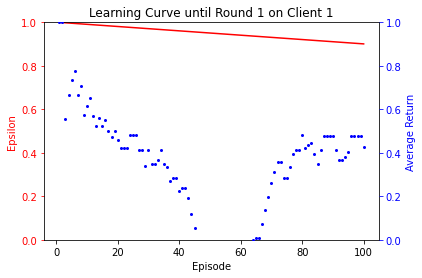

Agent 2 learning curve


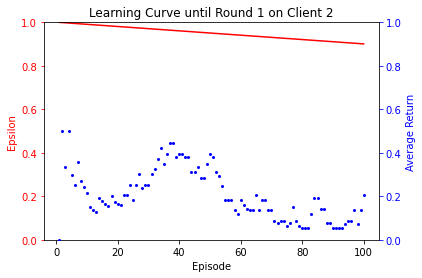

>>> SERVER TRAINING ROUND 2/10 <<<
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen 

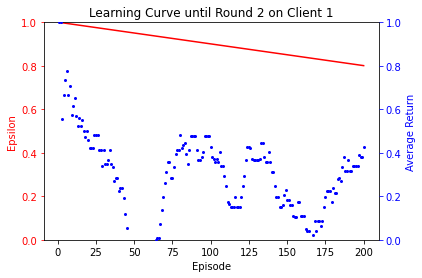

Agent 2 learning curve


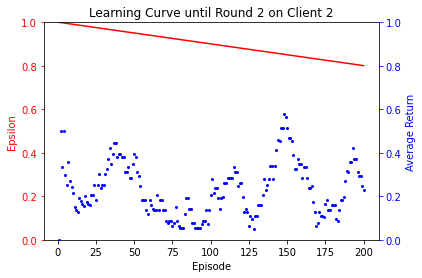

>>> SERVER TRAINING ROUND 3/10 <<<
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
Resetting to behavior: Behavior.CNC_THETICK
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
corr

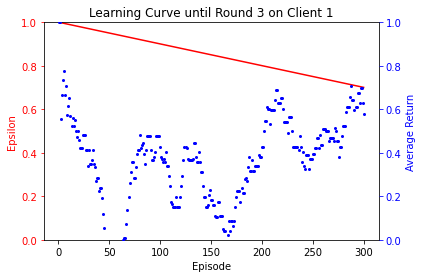

Agent 2 learning curve


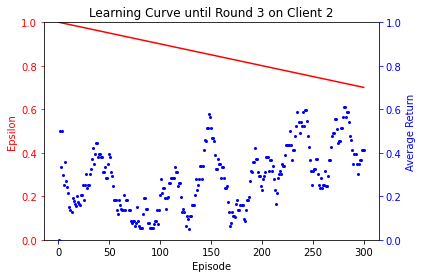

>>> SERVER TRAINING ROUND 4/10 <<<
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen 

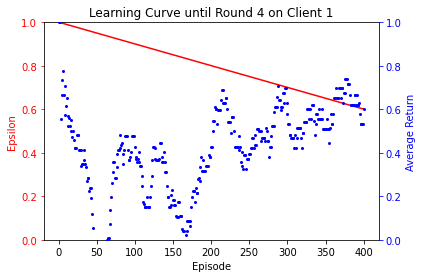

Agent 2 learning curve


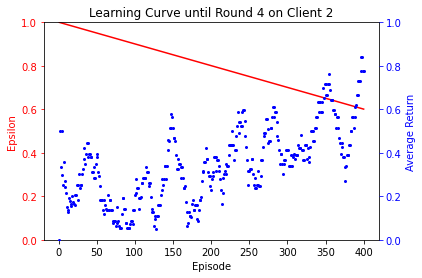

>>> SERVER TRAINING ROUND 5/10 <<<
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor


KeyboardInterrupt: 

In [14]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

ae_path = f"{experiment_path}/ae_model_pi3.pth"
ae_interpreter = get_pretrained_ae(path=ae_path, dims=46)

EPSILON_START = 1.0
EPSILON_DEC = 1e-3
EPSILON_END = 0.01
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 100
N_SAMPLES = 1000

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

'''
sampling_probabilities_1 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

sampling_probabilities_2 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

sample_matrix = np.vstack([n_samples_1, n_samples_2])

#print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
#print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")
'''

environment_01 = SensorEnvironment(training_data, interpreter=ae_interpreter, state_samples=SAMPLES)
environment_02 = SensorEnvironment(training_data, interpreter=ae_interpreter, state_samples=SAMPLES)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

evaluations = [Evaluation.LEARNING_CURVE]
server.run_federation(evaluations=evaluations, evaluation_frequency=1)